หากต้องการใช้ไลบรารีสนับสนุน mlxtend (https://github.com/rasbt/mlxtend) 
สำหรับพล็อตเส้นแสดงเขตการจำแนก สามารถติดตั้งไลบรารีโดยรันเซลล์ด้านล่าง

In [ ]:
#!pip install mlxtend

นำเข้าไลบรารีทั้งหมดที่ใช้งาน

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.io import loadmat
import sklearn
import sklearn.datasets
from mlxtend.plotting import plot_decision_regions

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

พื่อความสะดวกจะสร้างฟังก์ชันสำหรับพล็อตความแม่นยำและค่าสูญเสีย โดยสามารถเรียกใช้ในตัวอย่างอื่นที่จะนำเสนอต่อไป

In [ ]:
def plot_acc_loss(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(len(acc)) # Get number of epochs

    acc_txt = str(round(acc[len(acc)-1]*100,2))
    val_acc_txt = str(round(val_acc[len(val_acc)-1]*100,2))

    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(epochs, acc,'r',epochs,val_acc,'b')
    ax1.set_title('Training and validation accuracy')
    ax1.legend(["Training acc = "+acc_txt+" %","Validation acc = "+val_acc_txt+" %"])

    loss_txt = str(round(loss[len(loss)-1],2))
    val_loss_txt = str(round(val_loss[len(val_loss)-1],2))

    ax2.plot(epochs, loss, 'r',epochs, val_loss, 'b')
    ax2.legend(["Training loss = "+loss_txt,"Validation loss = "+val_loss_txt])
    ax2.set_title('Training and validation loss');



## 3.3 การเตรียมข้อมูลและตั้งค่าพารามิเตอร์

ในหัวข้อนี้จะกล่าวถึงวิธีการปรับปรุงข้อมูลก่อนเริ่มผึกและการตั้งค่าน้ำหนักเพื่อช่วยในการฝึกโมเดลได้ดีขึ้น  

### 3.3.1 การทำอินพุตให้เป็นบรรทัดฐาน

ข้อสังเกตหนึ่งของอินพุตในระนาบ 2 มิติที่ใช้ในตัวอย่าง 3.1 - 3.3 คือทั้งสองแกนมีค่าเฉลี่ยเข้าใกล้ศูนย์ 
และความแปรปรวนประมาณใกล้เคียงกัน ซึ่งเป็นคุณสมบัติที่ช่วยในการลดค่าเกรเดียนต์ของฟังก์ชันมูลค่า 
คือทำให้สามารถใช้อัตราการเรียนรู้ที่มีค่ามากขึ้น ดังนั้นในกรณีทั่วไปที่อินพุตอาจมีค่าเฉลี่ยและความแปรปรวนแตกต่างกัน 
วิธีหนึ่งที่ช่วยลดเวลาการฝึกลงได้คือการทำอินพุตให้เป็นบรรทัดฐาน 
(normalizing) 
$$
\tilde{x} = \frac{x - \mu}{\sigma} \tag{3.7}
$$
โดยค่าเฉลี่ย $\mu$ และความแปรปรวน $\sigma$ คำนวณได้จาก
$$
\mu = \frac{1}{m}\sum_{i=1}^mx^{(i)} \tag{3.8}
$$
$$
\sigma^2 = \frac{1}{m}\sum_{i=1}^m(x^{(i)}-\mu)^2 \tag{3.9}
$$

### 3.3.2 การกำหนดค่าเริ่มต้นของพารามิเตอร์

การกำหนดค่าเริ่มต้นของเมทริกซ์ค่าน้ำหนัก $W$ ที่เหมาะสมมีความสำคัญอย่างยิ่งต่อการฝึกโมเดลในการเรียนรู้เชิงลึก 
สิ่งที่ต้องคำนึงอย่างแรกคือไม่สามารถกำหนด $W = 0$ เป็นค่าเริ่มต้นได้ เพราะจะเกิดปัญหาจากความสมมาตร 
(แตกต่างจากค่าเอนเอียง $b$ ที่สามารถตั้งค่าเริ่มต้นเป็นศูนย์ได้) ค่าของ $W$ ต้องเป็นค่าสุ่มเพื่อไม่ให้เกิดความสมมาตรของโครงข่าย

**ตัวอย่าง 3.4**

สำหรับตัวอย่างในหัวข้อย่อยนี้จะเป็นปัญหาการจำแนกทวิภาคโดยใช้ข้อมูลจากไลบรารี sklearn ที่มีลักษณะเป็นวงกลมซ้อนกัน 
เขียนฟังก์ชัน load_circles_dataset() และเรียกใช้ฟังก์ชันที่จะพล็อตจุดข้อมูลดังในรูปที่ 3.14

In [4]:
def load_circles_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    train_Y = train_Y[:,np.newaxis]
    test_Y = test_Y[:,np.newaxis]
    
    # Visualize the data
    for i in range(len(train_Y)):
        if train_Y[i,0] == 1:
            plt.scatter(train_X[i,0],train_X[i,1],c='orange', marker='^',s=40)
        else:
            plt.scatter(train_X[i,0],train_X[i,1],c='blue', marker='s',s=40)    
    
    return train_X, train_Y, test_X, test_Y

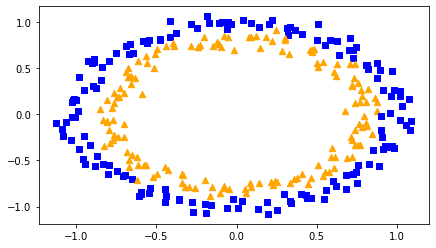

In [6]:
train_X, train_Y, test_X, test_Y = load_circles_dataset()

รูปที่ 3.14 ชุดข้อมูลสองประเภทที่เรียงตัวเป็นวงกลมซ้อนกัน

ในตัวอย่างนี้ต้องการแสดงว่าหากกำหนดค่าเริ่มต้นของค่าน้ำหนักเป็นศูนย์จะทำให้ไม่สามารถฝึกโมเดลให้เรียนรู้ได้เนื่องจากปัญหาการสมมาตร 
การสร้างโมเดลโดยไลบรารี TF สามารถกำหนดการตั้งค่าเริ่มต้นในแต่ละชั้นได้โดยใช้อาร์กิวเมนต์ kernel_initilizer และ bias_initializer 
สำหรับค่าน้ำหนัก $W$ และค่าเอนเอียง $b$ ตามลำดับ ตัวอย่างนี้จะทดลองกำหนดให้เป็นศูนย์ทั้งหมด

In [54]:
model0 = Sequential([
    Flatten(input_shape=[2]),
    Dense(10, kernel_initializer='zeros',bias_initializer='zeros', activation='relu'),
    Dense(5, kernel_initializer='zeros',bias_initializer='zeros', activation = 'relu'),
    Dense(1, kernel_initializer='zeros',bias_initializer='zeros', activation = 'sigmoid')
])

คอมไพล์และฝึกโมเดลเป็นจำนวน 2,000 รอบ 

In [55]:
model0.compile(optimizer=SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
history0 = model0.fit(train_X, train_Y, epochs=2000, validation_data=(test_X,test_Y),verbose=0)

เมื่อพล็อตค่าความแม่นยำและค่าสูญเสียจะได้ดังรูปที่ 3.15 จะเห็นได้ว่าค่าความแม่นยำและค่าสูญเสียไม่มีแนวโน้มในทิศทางดีขึ้นเมื่อผ่านการฝึกตามจำนวนรอบ 
ดังนั้นจึงคาดเดาได้ว่าโมเดลไม่สามารถจำแนกประเภทข้อมูลได้ ยืนยันได้จากพล็อตในรูปที่ 3.16 ซึ่งไม่มีการแสดงเส้นแบ่งเขตในการจำแนกประเภท 

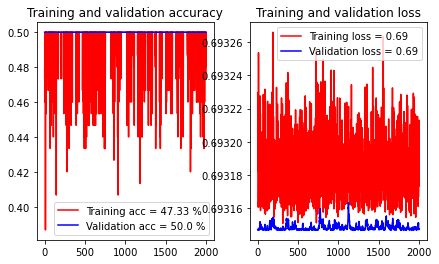

In [58]:
plot_acc_loss(history0)

รูปที่ 3.15 ค่าความแม่นยำและค่าสูญเสียจากการฝึกเมื่อกำหนดค่าเริ่มต้น $W = 0$

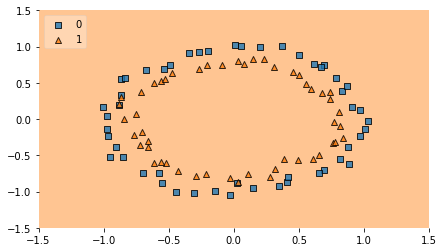

In [59]:
plot_decision_regions(test_X, np.squeeze(test_Y), clf=model0, legend=2)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

รูปที่ 3.16 ผลการจำแนกข้อมูลของโมเดลที่กำหนดค่าเริ่มต้น $W = 0$

จากตัวอย่างที่ผ่านมาสรุปได้ว่าจะต้องตั้งค่าเริ่มต้นของน้ำหนักเป็นค่าสุ่มเพื่อไม่ให้เกิดปัญหาสมมาตร 
ประเด็นต่อมาคือหากกำหนดค่าเริ่มต้นของ $W$ ไม่เหมาะสมจะเกิดกรณีที่เรียกว่า การสูญหาย (vanishing) หรือการเพิ่มสูง 
(explode) ของค่าเกรเดียนต์ โดยเฉพาะเมื่อโมเดลมีความลึกมาก คือมีจำนวนชั้นแฝงมาก ผลคือการฝึกจะใช้เวลานานและไม่ได้ผลดี 

**ตัวอย่าง 3.5**

ในตัวอย่างนี้จะทดลองกับข้อมูลเดิมในตัวอย่างที่ผ่านมา โดยตั้งค่าเริ่มต้นของน้ำหนักเป็นค่าสุ่มในช่วง 0.0 - 10.0 ส่วนค่าเอนเอียงสามารถตั้งให้เป็นศูนย์ได้ 
คอมไพล์และฝึกโมเดลจำนวน 2,000 รอบเท่าเดิม 

In [60]:
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=10)

In [61]:
model1 = Sequential([
    Flatten(input_shape=[2]),
    Dense(10, kernel_initializer=initializer,bias_initializer='zeros', activation='relu'),
    Dense(5, kernel_initializer=initializer,bias_initializer='zeros', activation = 'relu'),
    Dense(1, kernel_initializer=initializer,bias_initializer='zeros', activation = 'sigmoid')
])

In [62]:
model1.compile(optimizer=SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
history1 = model1.fit(train_X, train_Y, epochs=2000, validation_data=(test_X,test_Y),verbose=0)

เมื่อพล็อตความแม่นยำและค่าสูญเสียในรูปที่ 3.17 จะเห็นว่าหลังจากฝึก 2,000 รอบ โมเดลสามารถเรียนรู้ได้ในระดับหนึ่ง 
แต่ค่าความแม่นยำยังไม่เป็นที่น่าพอใจ สามารถตรวจสอบผลการจำแนกได้ดังในรูปที่ 3.18

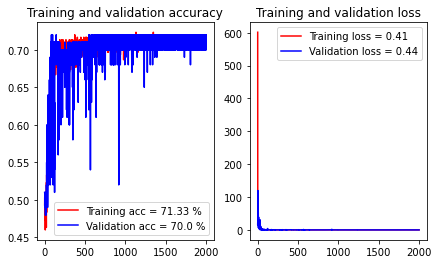

In [64]:
plot_acc_loss(history1)

รูปที่ 3.17 ค่าความแม่นยำและค่าสูญเสียจากการฝึกเมื่อกำหนดค่าเริ่มต้น $W \in [0,10]$

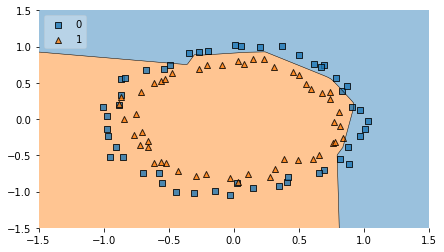

In [65]:
plot_decision_regions(test_X, np.squeeze(test_Y), clf=model1, legend=2)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

รูปที่ 3.18 ผลการจำแนกข้อมูลของโมเดลที่กำหนดค่าเริ่มต้น $W \in [0,10]$

จากตัวอย่างที่ผ่านมาจะเห็นว่าค่าเริ่มต้นของ $W$ มีผลต่อการฝึกโมเดล 
เราต้องการกำหนดค่าที่เหมาะสมเพื่อมิให้เกิดปัญหาการสูญหายหรือการเพิ่มสูงของค่าเกรเดียนต์ ซึ่งไลบรารี TF 
มีตัวเลือกให้หลายรูปแบบตามที่มีผู้นำเสนอในบทความ

เพื่อให้เข้าใจได้ง่ายขึ้น พิจารณาเอาต์พุตที่เป็นผลรวมเชิงเส้นของอินพุตกับค่าน้ำหนัก
$$
z = w_1x_1 + w_2x_2 + \ldots + w_nx_n \tag{3.10}
$$

หากต้องการให้เอาต์พุตมีค่าในช่วงที่เหมาะสม เมื่อจำนวน $n$ มากขึ้นจะต้องการให้ค่าน้ำหนักลดลง 
ดังนั้นนอกจากเลือกค่าของ $W$ เป็นค่าสุ่มแล้ว จะปรับมาตราส่วนค่าเริ่มต้นขึ้นกับ $n$ แนวคิดที่มีผู้นำเสนอคืิอ 
กำหนดค่าความแปรปรวนของ $W$
$$
Var(w_i) = \frac{1}{n} \tag{3.11}
$$ 
เมื่อฟังก์ชันกระตุ้นเป็นแบบ $tanh$ มีชื่อเรียกว่า "Xavier initialization" ตามชื่อผู้เสนอในบทความ 

ส่วนกรณีฟังก์ชันกระตุ้นเป็นแบบ ReLU จะกำหนด
$$
Var(w_i) = \frac{2}{n} \tag{3.12}
$$ 
เรียกว่า "He initialization" ตามชื่อผู้เสนอ 
สังเกตว่าหากเป็นชั้นที่ $l$ ค่าของ $W^{[l]}$ จะถูกตั้งให้มีความแปรปรวน$\frac{1}{n^{[l-1]}}$ (Xavier) หรือ 
$\frac{2}{n^{[l-1]}}$ (He) ถ้าเขียนโค้ดไพธอนเองจะมีลักษณะดังนี้
```python
W_l = np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(1./layers_dims[l-1]) # Xavier
W_l = np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(2./layers_dims[l-1]) # He
```

**ตัวอย่าง 3.6**

จากข้อมูลเดิมในตัวอย่างก่อนหน้านี้ ทดลองตั้งค่าเริ่มต้น $W$ โดยกำหนดค่าความแปรปรวนแบบ He ทำได้โดยตั้ง initializer เป็นแบบ HeNormal()

In [43]:
he_initializer = tf.keras.initializers.HeNormal()

In [49]:
model2 = Sequential([
    Flatten(input_shape=[2]),
    Dense(10, kernel_initializer=he_initializer,bias_initializer='zeros', activation='relu'),
    Dense(5, kernel_initializer=he_initializer,bias_initializer='zeros', activation = 'relu'),
    Dense(1, kernel_initializer=he_initializer,bias_initializer='zeros', activation = 'sigmoid')
])

ฝึกโมเดลด้วยจำนวนรอบเท่าเดิม ตรวจสอบความแม่นยำและค่าสูญเสีย (รูปที่ 3.19) รวมถึงพล็อตขอบเขตการจำแนก (รูปที่ 3.20) 
จะพบว่าได้โมเดลที่พยากรณ์ได้แม่นยำขึ้น

In [50]:
model2.compile(optimizer=SGD(learning_rate=0.01),loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
history2 = model2.fit(train_X, train_Y, epochs=2000, validation_data=(test_X,test_Y),verbose=0)

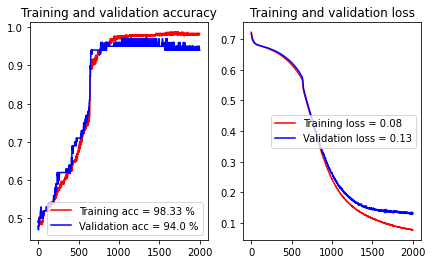

In [52]:
plot_acc_loss(history2)

รูปที่ 3.19 ค่าความแม่นยำและค่าสูญเสียจากการฝึกเมื่อกำหนดค่าเริ่มต้นของ $W$ แบบ HeNormal()

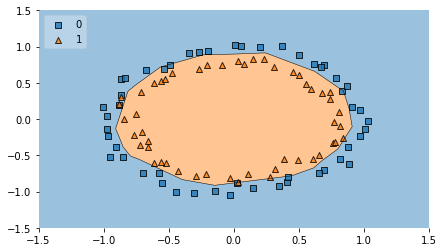

In [53]:
plot_decision_regions(test_X, np.squeeze(test_Y), clf=model2, legend=2)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

รูปที่ 3.20 ผลการจำแนกข้อมูลของโมเดลที่ตั้งค่า $W$ โดยตัวเลือก HeNormal()



<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>